In [1]:
import numpy as np
import tensorflow as tf
from numpy import newaxis
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from unityagents import UnityEnvironment
import cv2

# Object detection tensorflow by google

In [2]:
import os
from utils import label_map_util
from utils import visualization_utils as vis_util
import pickle

# What model to download.
MODEL_NAME = 'ssd_mobilenet_v1_coco_2017_11_17'

# Path to frozen detection graph. This is the actual model that is used for the object detection.
PATH_TO_CKPT = MODEL_NAME + '/frozen_inference_graph.pb'

# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = os.path.join('data', 'mscoco_label_map.pbtxt')

NUM_CLASSES = 90

detection_graph = tf.Graph()
with detection_graph.as_default():
    od_graph_def = tf.GraphDef()
    with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
        serialized_graph = fid.read()
        od_graph_def.ParseFromString(serialized_graph)
        tf.import_graph_def(od_graph_def, name='')
        
label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=NUM_CLASSES, use_display_name=True)
category_index = label_map_util.create_category_index(categories)

# Load environment

In [3]:
env_name = "autocar2_human_gendata"
env = UnityEnvironment(file_name=env_name)

# Examine environment parameters
print(str(env))

# Set the default brain to work with
default_brain = env.brain_names[0]
brain = env.brains[default_brain]

INFO:unityagents.environment:
'Academy' started successfully!


Unity Academy name: Academy
        Number of brains: 1
        Reset Parameters :
		
Unity brain name: Brain
        Number of observations (per agent): 2
        State space type: continuous
        State space size (per agent): 3
        Action space type: continuous
        Action space size (per agent): 2
        Memory space size (per agent): 0
        Action descriptions: , 


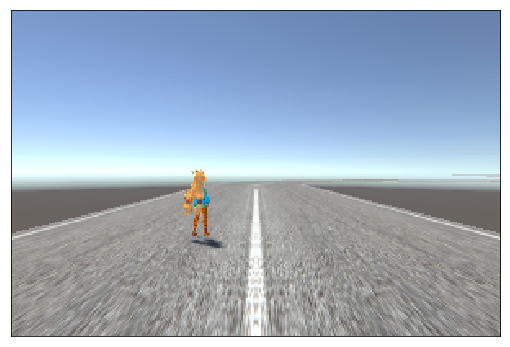

In [4]:
env_info = env.reset(train_mode=False)[default_brain]

plt.figure(figsize=(9,6))
plt.imshow(env_info.observations[1][0])
plt.xticks([]), plt.yticks([])
plt.show()

# Test visualization

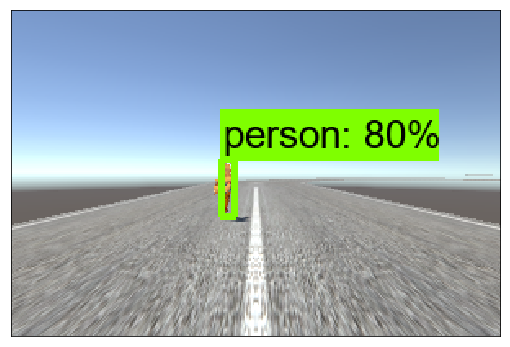

[  1.18065262e-02   1.88532150e+02   8.03541400e+00]


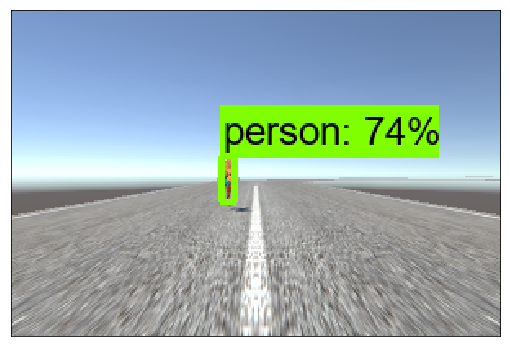

[  4.06154543e-02   1.88532150e+02   8.30628700e+00]


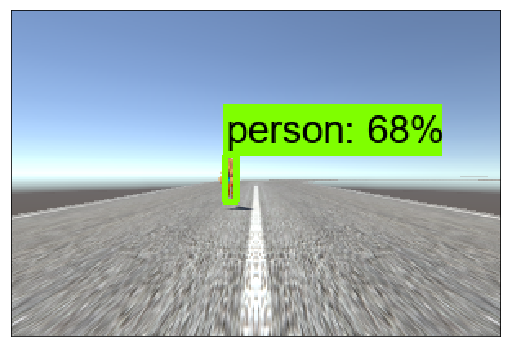

[  3.81406200e-02   1.88532150e+02   8.57774600e+00]


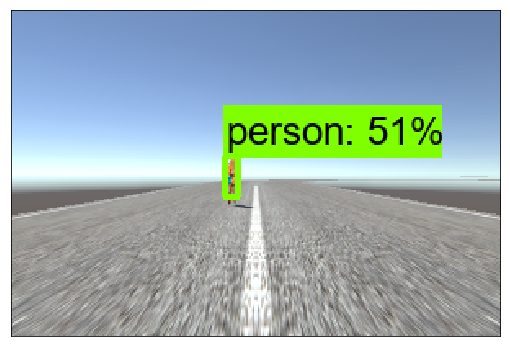

[  3.81414200e-02   1.88532150e+02   8.84973800e+00]


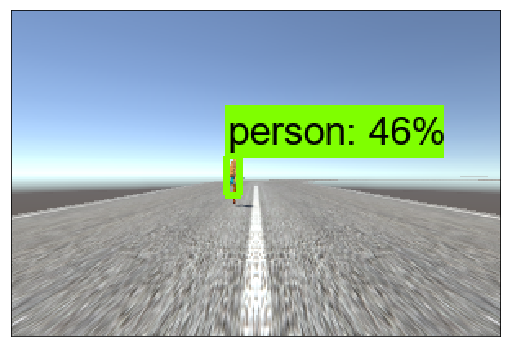

[  3.81415700e-02   1.88532150e+02   9.12221300e+00]


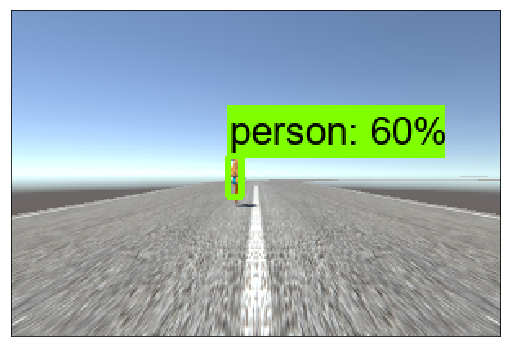

[  3.81414779e-02   1.88532150e+02   9.39513200e+00]


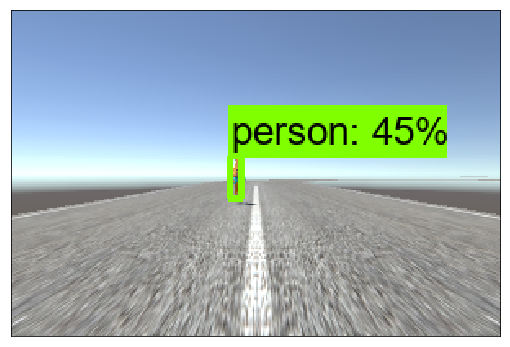

[  3.81414331e-02   1.88532150e+02   9.66845500e+00]


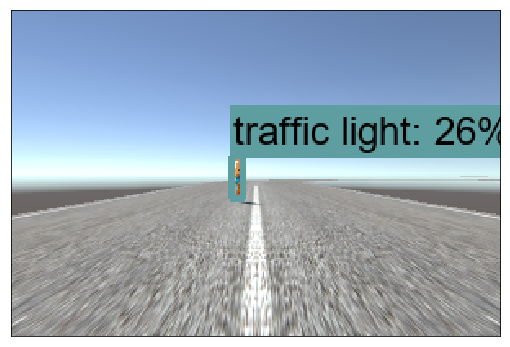

[  3.81415226e-02   1.88532150e+02   9.94215000e+00]


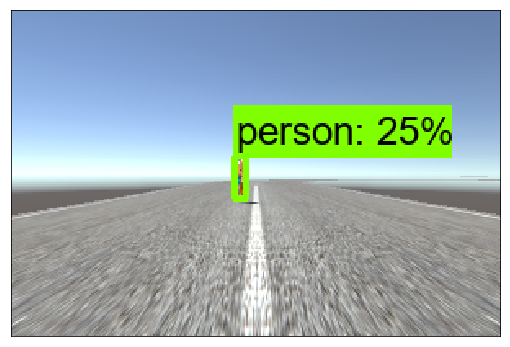

[  3.81416120e-02   1.88532150e+02   1.02161865e+01]


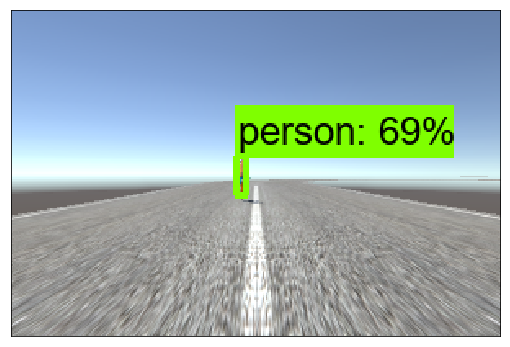

[  3.81414071e-02   1.88532135e+02   1.04905376e+01]


In [5]:
env_info = env.reset(train_mode=False)[default_brain]

with detection_graph.as_default():
    with tf.Session(graph=detection_graph) as sess:
        # Definite input and output Tensors for detection_graph
        image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')
        detection_boxes = detection_graph.get_tensor_by_name('detection_boxes:0')
        detection_scores = detection_graph.get_tensor_by_name('detection_scores:0')
        detection_classes = detection_graph.get_tensor_by_name('detection_classes:0')
        num_detections = detection_graph.get_tensor_by_name('num_detections:0')
        # the array based representation of the image will be used later in order to prepare the
        # result image with boxes and labels on it.
        for _ in range(10):
            for _ in range(10):
                env_info = env.step([0.0,0.0])[default_brain]
        
            image_np = (env_info.observations[1][0]*255).astype(np.uint8)
            # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
            image_np_expanded = np.expand_dims(image_np, axis=0)
            # Actual detection.
            (boxes, scores, classes, num) = sess.run(
                      [detection_boxes, detection_scores, detection_classes, num_detections],
                      feed_dict={image_tensor: image_np_expanded})
            # Visualization of the results of a detection.
            vis_util.visualize_boxes_and_labels_on_image_array(
                image_np,
                np.squeeze(boxes),
                np.squeeze(classes).astype(np.int32),
                np.squeeze(scores),
                category_index, 
                min_score_thresh = scores[0][0]-1e-9,
                use_normalized_coordinates=True,
                line_thickness=2)
            plt.figure(figsize=(9,6))
            plt.xticks([]), plt.yticks([])
            plt.imshow(image_np)
            plt.show()
            print(env_info.states[0])

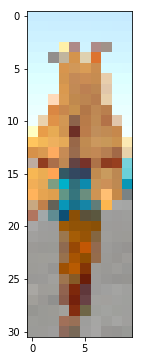

173.488953
(31, 10, 3)


In [6]:
IMG_H = 200
IMG_W = 300

plt.figure(figsize=(9,6))
plt.imshow(env_info.observations[1][0][int(IMG_H*boxes[0][0][0]):int(IMG_H*boxes[0][0][2]), int(IMG_W*boxes[0][0][1]):int(IMG_W*boxes[0][0][3])])
plt.show()
print(env_info.states[0][1])
print(env_info.observations[1][0][int(IMG_H*boxes[0][0][0]):int(IMG_H*boxes[0][0][2]), int(IMG_W*boxes[0][0][1]):int(IMG_W*boxes[0][0][3])].shape)

In [7]:
def save_img(env_info, boxes, classes, ind, size=(20, 40), directory='human_imgs_lowres'):
    """
    ind = index of the img to avoid same name
    """
    if classes[0][0] != 1: # if the recognition is not a person, don't do anything
        return
    img = cv2.cvtColor((env_info.observations[1][0]*255).astype(np.uint8)[int(IMG_H*boxes[0][0][0]):int(IMG_H*boxes[0][0][2]), 
                                                                          int(IMG_W*boxes[0][0][1]):int(IMG_W*boxes[0][0][3])], cv2.COLOR_RGB2BGR)
    img = cv2.resize(img, size)
    angle = int(env_info.states[0][1])
#     direction = ""
#     angle_thr = 30
#     if angle > angle_thr and angle < 180-angle_thr:
#         direction += "l"
#     elif angle > 180+angle_thr and angle < 360-angle_thr:
#         direction += "r"
#     if angle > 90+angle_thr and angle < 270-angle_thr:
#         direction += "u"
#     elif angle < 90-angle_thr or angle > 270+angle_thr:
#         direction += "d"
#     cv2.imwrite(directory+'/'+direction+'_'+str(ind)+".jpg", img)
    cv2.imwrite(directory+'/'+str(angle)+'_'+str(ind)+".jpg", img)    

In [8]:
def save_distance(env_info, boxes, classes):
    global X, y
    if classes[0][0] != 1: # if the recognition is not a person, don't do anything
        return
    X += [boxes[0][0]]
    y += [env_info.states[0][2]]

# Generate training data finally

In [8]:
eps = 1000
X = []
y = []

with detection_graph.as_default():
    with tf.Session(graph=detection_graph) as sess:
        # Definite input and output Tensors for detection_graph
        image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')
        detection_boxes = detection_graph.get_tensor_by_name('detection_boxes:0')
        detection_scores = detection_graph.get_tensor_by_name('detection_scores:0')
        detection_classes = detection_graph.get_tensor_by_name('detection_classes:0')
        num_detections = detection_graph.get_tensor_by_name('num_detections:0')
        # the array based representation of the image will be used later in order to prepare the
        # result image with boxes and labels on it.
        
        for ep in range(eps): # run for @eps episodes (random starting points)
            if (ep+1)%100 == 0:
                print('\r', ep+1, end=' '*10)
            env_info = env.reset(train_mode=False)[default_brain]
            
            for i in range(10):
                for j in range(6): # walk for 50 frames, and save imgs every 6 frames
                    env_info = env.step([0.0,0.0])[default_brain]

                image_np = (env_info.observations[1][0]*255).astype(np.uint8)
                # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
                image_np_expanded = np.expand_dims(image_np, axis=0)
                # Actual detection.
                (boxes, scores, classes, num) = sess.run(
                          [detection_boxes, detection_scores, detection_classes, num_detections],
                          feed_dict={image_tensor: image_np_expanded})
                save_img(env_info, boxes, classes, ep*10+i+1)
#                 save_distance(env_info, boxes, classes)

 1000          

In [6]:
X = np.vstack(X)
y = np.vstack(y)

with open('bounding_box_coordinates.pickle', 'wb') as handle:
    pickle.dump(X, handle)
    
with open('distances.pickle', 'wb') as handle:
    pickle.dump(y, handle)

In [9]:
env.close()